<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Implementation" data-toc-modified-id="Implementation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Implementation</a></span><ul class="toc-item"><li><span><a href="#SVD" data-toc-modified-id="SVD-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>SVD</a></span></li><li><span><a href="#数据中心化" data-toc-modified-id="数据中心化-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>数据中心化</a></span></li><li><span><a href="#线性回归采用SVD方法" data-toc-modified-id="线性回归采用SVD方法-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>线性回归采用SVD方法</a></span></li><li><span><a href="#岭回归采用SVD方法" data-toc-modified-id="岭回归采用SVD方法-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>岭回归采用SVD方法</a></span></li><li><span><a href="#套索回归采用坐标下降（coordinate-descent）方法" data-toc-modified-id="套索回归采用坐标下降（coordinate-descent）方法-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>套索回归采用坐标下降（coordinate descent）方法</a></span></li></ul></li><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Linear Regression</a></span></li><li><span><a href="#Ridge-Regression" data-toc-modified-id="Ridge-Regression-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Ridge Regression</a></span></li><li><span><a href="#Lasso" data-toc-modified-id="Lasso-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Lasso</a></span></li><li><span><a href="#Check-with-sklearn" data-toc-modified-id="Check-with-sklearn-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Check with sklearn</a></span></li><li><span><a href="#Benchmark" data-toc-modified-id="Benchmark-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Benchmark</a></span></li></ul></div>

# Implementation

* $X_{ij}$表示样本$i$的特征$j$的数值。 $\mathbf{X}$为$m\times d$大小的矩阵，其中$m$为样本的数量，$d$为特征的数量。
* $\mathbf{y}$为列向量$(...,y_i,...)^T$。
* $\mathbf{x}_i$为列向量$(...,X_{ij},...)^T$。
* $\mathbf{w}$为列向量$(...,w_j,...)^T$。



## SVD
对于一个矩阵$A\in R^{m\times n}$，我们将他分解为
$A = U \Sigma V^T$
其中$U\in R^{m\times m}$，$V\in R^{n\times n}$，$\Sigma\in R^{m\times n}$，且$U$和$V$为正交矩阵，$\Sigma$为"对角"矩阵。
其中
$$
\Sigma={\rm diag}_{m\times n}(\sigma_1,\sigma_2,...,\sigma_r,0,...),\quad r \le \min (m,n)
$$

$$
A_{ij} = \sum_{k\le r} U_{ik}\Sigma_k V_{ik}
$$


## 数据中心化
损失函数可以表示为
$$
L = \sum_i (y_i - X_{ij} w_j - b)^2 + f(w_j)
$$



数据中心化之后
$$
\sum_j X_{ij} = 0
$$
$$
\sum_j y_j = 0
$$


对$b$满足
$$
\partial_b L = \sum_i (y_i - X_{ij} w_j - b) = \sum_i b
$$
于是
$$
b = 0
$$
优化问题变为
$$
L = \sum_i (y_i -\sum_j X_{ij} w_j)^2
$$

由于
$$
y(\hat{\mathbf{x}}) = \sum_j w_j (\hat{x}_j - \overline{x}_j) + \overline{y}
$$

数据中心化前的偏置项为$b^\prime$
$$b^\prime = \overline{y} - \sum_i w_i \overline{x_i}$$
权重为
$$w^\prime = w$$

## 线性回归采用SVD方法
$$
L = \sum_i (y_i - X_{ij} w_j)^2
=  (\mathbf{y} - \mathbf{X}\cdot\mathbf{w})^T \cdot (\mathbf{y} - \mathbf{X}\cdot\mathbf{w})
$$

对任意$w_j$满足
$$
0 = \partial_{w_j} L = \sum_i 2 (y_i - X_{ij} w_j) (-X_{ij}) = -2 \mathbf{X}^T (\mathbf{y} - \mathbf{X}\mathbf{w}) 
$$
对$\mathbf{X}$做SVD
$$
V\Sigma^T U^T (\mathbf{y} - U\Sigma V^T\mathbf{w}) = 0
$$
$V$为正交矩阵一定可逆且逆为$V^T$，于是
$$
\Sigma^T \Sigma V^T\mathbf{w} = \Sigma^T U^T \mathbf{y}
$$
$\Sigma^T \Sigma$为$n \times n$的方型矩阵，$\Sigma^T \Sigma = {\rm diag}(\sigma_1^2, ..., \sigma_r^2, 0, ...)$

$\Sigma$不一定可逆，因为$\Sigma$可能包含全部为0的行。
如果$\Sigma$可能不包含全部为0的行，则
$$
\mathbf{w} = V (\Sigma^T \Sigma)^{-1} \Sigma^T U^T \mathbf{y}
$$


如果$\Sigma$可能包含全部为0的行，对于$\Sigma$全部为0的行，无论$V^T W$取多少，方程两边都为0，方程自然平衡，于是方程有无穷多个解。
这是因为此时$X$的秩($r$)小于$n=d+1$，方程$\mathbf{y} - \mathbf{X}\mathbf{w}$有无穷解，$L$可以达到0。此时我们为了得到确定的$\mathbf{w}$。我们求使得$L$最小的$\mathbf{w}$中，使得$|\bf{w}|^2$最小的。
由于
$$
|\mathbf{w}|^2 =  |V^T \mathbf{w}|^2 
$$
对于$\Sigma$全为0的行，应当是相应行的$|V^T \mathbf{w}|$设为0。
于是
$$
(\Sigma^T \Sigma)_r V^T\mathbf{w} = (\Sigma^T)_r U^T_{r\times m} \mathbf{y}
$$
其中$(\Sigma^T \Sigma)_r = {\rm diag}(\sigma_1^2, ..., \sigma_r^2)$，$\Sigma_r = {\rm diag}(\sigma_1, ..., \sigma_r)$，
$U^T_{r\times m}$表示$U$的前$r$行，最后有
$$
 \mathbf{w} = V_{n \times r} \Sigma_r^{-1} U^T_{r\times m} \mathbf{y}
$$
$V_{m \times r}$表示$U$的前$r$列。



## 岭回归采用SVD方法
$$
L = \sum_i (y_i - X_{ij} w_j)^2
=  (\mathbf{y} - \mathbf{X}\cdot\mathbf{w})^T \cdot (\mathbf{y} - \mathbf{X}\cdot\mathbf{w})
+ \lambda \mathbf{w}^T  \mathbf{w}
$$
其中$\lambda = \alpha$
$$
0 = \partial_{w_j} L = \sum_i 2 (y_i - X_{ij} w_j) (-X_{ij}) + 2\Lambda_{ij} w_j$$
$$ 
0 = -2 \mathbf{X}^T (\mathbf{y} - \mathbf{X}\mathbf{w}) + 2\Lambda \mathbf{w}
$$

$$
(\lambda I +\Sigma^T \Sigma) V^T\mathbf{w} = \Sigma^T U^T \mathbf{y}
$$

由于 $(\lambda I + \Sigma^T \Sigma)$可逆
$$
\mathbf{w} = V (\lambda I + \Sigma^T \Sigma)^{-1}\Sigma^T U^T \mathbf{y}
$$
进一步化简为
$$
\mathbf{w} = V_{n\times r}(V^T \Lambda V + \Sigma^T \Sigma)^{-1}_{r}\Sigma^T_{r} U^T_{r\times m} \mathbf{y}
$$




## 套索回归采用坐标下降（coordinate descent）方法
$$
L = \sum_i (y_i - \sum_j X_{ij} w_j)^2 + \lambda \sum_j |w_j|
$$
其中$\lambda = 2\alpha m$。
loss函数中与$w_k$有关的项为
$$
L = \sum_i (y_i - \sum_j X_{ij} w_j)^2
=\sum_i (y_i - \sum_j X_{ij\neq k} w_j - X_{ik}w_k)^2 + \lambda \sum_j |w_j|
$$

$$L \sim \sum_i (X_{ik}w_k)^2 + 2 \sum_i \left(\sum_j X_{ij\neq k }w_{j}- y_i\right) X_{ik} w_{k}  + \lambda |w_k|$$

$$L \sim \left(\sum_i X^2_{ik}\right) w_k^2 + 2 \sum_i \left(\sum_j X_{ij}w_{j} - X_{ik} w_{k}  - y_i\right) X_{ik} w_{k} + \lambda |w_k|$$

定义
$$
A_j = \sum_i X^2_{ij}
$$

$$
B_{jk} = \sum_i X_{ij} X_{ik}
$$

$$
C_k = \sum_i y_i X_{ik}
$$

则
$$L \sim A_k w_k^2 + 2 \left(\sum_j B_{jk} w_j - A_k w_k  - C_k \right) w_k + \lambda |w_k|$$
注意大圆括号的项实际并不包含$w_k$。

设第$s$步，$w_j$数值为$w_j^{(s)}$，则

$$ L \sim A_k w_k^2 + 2 \left(\sum_j B_{j k} w_j^{(s)} - A_k w_k^{(s)}  - C_k \right) w_k + \lambda |w_k|$$

$$ L \sim A_k w_k^2 + 2 F_k w_k + \lambda |w_k|$$

优化$w_k$应该分情况讨论，设$w_k > 0$，则最优化位置为
$$
w_k = -(F_k + \lambda/2)/A_k
$$
自恰条件为
$$
F_k > -\lambda/2
$$

设$w_k < 0$，则最优化位置为
$$
w_k = -(F_k - \lambda/2)/A_k
$$
自恰条件为
$$
F_k > \lambda/2
$$
两者都不满足，那么$w_k = 0$



In [1]:
import numpy as np
class LinearRegression:
    
    def __init__(self):
        pass
     
    def fitQR(self, X, y):
        X = np.array(X)
        X=np.c_[X, np.ones(shape=(X.shape[0], 1), dtype=X.dtype)]
        Q, R=np.linalg.qr(X, mode='reduced')
        W=np.linalg.solve(R, Q.T.dot(y))
        self.coef_=W

    def fitSVD(self, X, y):
        X = np.array(X)
        Xmeans = X.mean(axis = 0)
        ymeans = y.mean(axis = 0)
        X = X - Xmeans
        y = y - ymeans
        U,D,VT = np.linalg.svd(X, full_matrices=False)
        # U m \times r
        # D r \times r
        # VT r \times n     
        
        # we don't need really remove the zeros rows
        #invD = D/(np.square(D) + self.alpha_)    
        invD = 1/np.where(np.abs(D)<1E-6, np.full(D.shape, 1E-6), D)
        
        W = VT.T.dot((invD * U.T.dot(y)))
        self.coef_ = W
        self.intercept_ = ymeans - W.dot(Xmeans)
        
    
    def fit(self,X,y):        
        self.fitSVD(X,y)
        
    def predict(self, X):
        assert X.ndim == 2
        return np.dot(X, self.coef_) + self.intercept_
        
        
class Ridge:
    
    def __init__(self, alpha = 0.01):
        self.alpha_ = float(alpha)
        pass
    
    def fit(self,X,y):
        self.fitSVD(X,y)
    

    def fitSVD(self, X, y):
        X = np.array(X)
        Xmeans = X.mean(axis = 0)
        ymeans = y.mean(axis = 0)
        X = X - Xmeans
        y = y - ymeans
        U,D,VT = np.linalg.svd(X, full_matrices=False)
        # U m \times r
        # D r \times r
        # VT r \times n
        
        lamb = max(1E-6, self.alpha_)
        invD = D/(np.square(D) + lamb) 
        W = VT.T.dot((invD*U.T.dot(y)))
        self.coef_ = W
        self.intercept_ = ymeans - W.dot(Xmeans)
                        
    def predict(self, X):
        assert X.ndim == 2
        return np.dot(X, self.coef_) + self.intercept_

class Lasso:
    
    def __init__(self,alpha = 0.01):
        self.alpha_ = float(alpha)
        pass
    
    def fit(self,X,y, max_iters=100):
        assert X.ndim == 2
        
        X = np.array(X)
        Xmeans = X.mean(axis = 0)
        ymeans = y.mean(axis = 0)
        X = X - Xmeans
        y = y - ymeans
        
        nfeatures = X.shape[1]
        
        W = np.zeros(nfeatures)
        

        B = X.T.dot(X)
        C = y.dot(X)
                
        lamb = 2*X.shape[0]*self.alpha_
        for it in range(max_iters):
            for k in range(nfeatures):
                
                Ak = B[k,k]
                
                Fk = B[:,k].dot(W) - Ak*W[k] - C[k]
                                
                if Fk < -lamb/2: # weight > 0
                    weight = -(Fk + lamb/2)/Ak
                elif Fk > lamb/2: # weight < 0
                    weight = -(Fk - lamb/2)/Ak
                else:
                    weight = 0.0

                W[k] = weight
                
            
        self.coef_ = W
        #print("W", W)
        #print("Xmeans", Xmeans)
        #print("ymeans", ymeans)
        self.intercept_ = ymeans - W.dot(Xmeans)
                            
    def predict(self, X):
        assert X.ndim == 2
        return np.dot(X, self.coef_) + self.intercept_



# Linear Regression

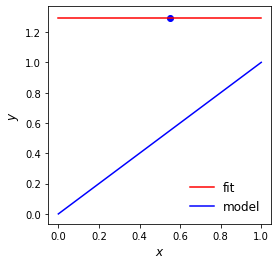

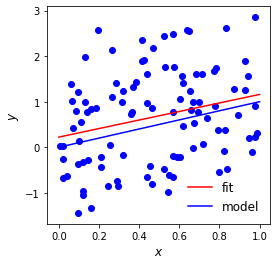

In [2]:
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

def get_data(M=1, N=100):
    np.random.seed(0)
    X = np.random.rand(N,M)
    w = np.arange(1,M+1)
    y = np.sum(w.reshape(1,M)*X, axis=1) + np.random.randn(N)
    return X,y,np.append(w,0)

def test_learner(lr, N = 100):
        
    X,y,w = get_data(1, N)
    lr.fit(X, y)

    X_plt = np.linspace(0, 1, 50)
    yhat_plt= lr.predict(X_plt[:,np.newaxis])

    fig=plt.figure(figsize=(4,4))
    plt.scatter(X, y, color="blue")
    plt.plot(X_plt, yhat_plt, label="fit", color="red")
    plt.plot(X_plt, X_plt[:]*w[0]+w[1], label="model", color="blue")
    plt.xlabel("$x$", fontsize="large")
    plt.ylabel("$y$", fontsize="large")
    plt.legend(frameon=False, fontsize="large")
    plt.show()

lr = LinearRegression()
test_learner(LinearRegression(), N=1)
test_learner(lr)

# Ridge Regression

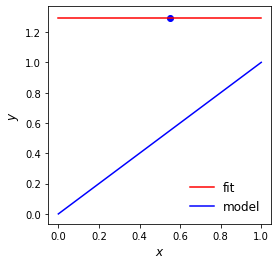

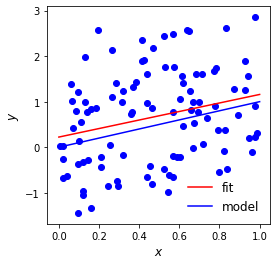

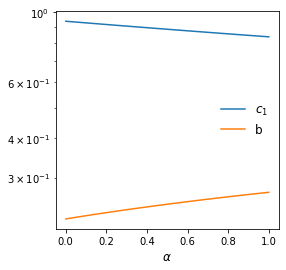

In [3]:
test_learner(Ridge(alpha=0.01), N=1)
test_learner(Ridge())

def test_shrinkage(cls, max_alpha = 1):
    X,y,w=get_data(1,100)
    alphas=[]
    cs=[]
    bs=[]
    alphas = max_alpha*np.power(10, np.linspace(-3, 0))
    for alpha in alphas:
        lr=cls(alpha)
        lr.fit(X, y)
        cs.append(lr.coef_)
        bs.append(lr.intercept_)

    cs=np.array(cs)

    plt.figure(figsize=(4,4))
    plt.plot(alphas, cs[:,0], label="$c_1$")
    plt.plot(alphas, bs, label="b")
    plt.yscale("log")
    plt.xlabel(r"$\alpha$", fontsize="large")
    plt.legend(frameon=False, fontsize="large")
    plt.show()

    
test_shrinkage(Ridge)

# Lasso

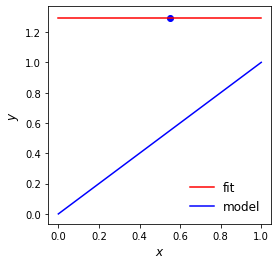

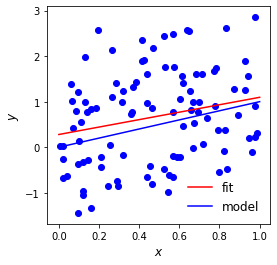

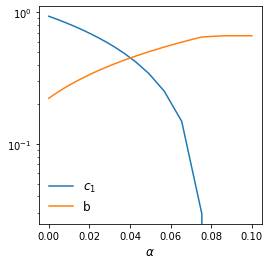

In [4]:
test_learner(Lasso(), N=1)
test_learner(Lasso())
test_shrinkage(Lasso, max_alpha=0.1)

# Check with sklearn

In [5]:
import sklearn as sk
import sklearn.linear_model

X, y, w = get_data(3, 10)
linear=LinearRegression()
linear.fit(X,y)

ridge=Ridge(alpha=1)
ridge.fit(X,y)

lasso=Lasso(alpha=1E-2)
lasso.fit(X,y)

sklr=sk.linear_model.LinearRegression()
sklr.fit(X, y)

skridge=sk.linear_model.Ridge(alpha=1)
skridge.fit(X, y)

sklasso=sk.linear_model.Lasso(alpha=1E-2)
sklasso.fit(X, y)

print("%30s %10s"%("LinearRegression","Mine"), end=" ")
print(linear.coef_, linear.intercept_)
print("%30s %10s"%("Ridge","Mine"), end=" ")
print(ridge.coef_, ridge.intercept_)
print("%30s %10s"%("Lasso","Mine"), end=" ")
print(lasso.coef_, lasso.intercept_)
print("%30s %10s"%("LinearRegression","sklearn"), end=" ")
print(sklr.coef_, sklr.intercept_)
print("%30s %10s"%("Ridge","sklearn"), end=" ")
print(skridge.coef_, skridge.intercept_)
print("%30s %10s"%("Lasso","sklearn"), end=" ")
print(sklasso.coef_, sklasso.intercept_)

              LinearRegression       Mine [1.76371755 3.3358603  4.86760526] -1.914671192484204
                         Ridge       Mine [1.14464218 1.21175218 2.16407904] 1.3497212361591169
                         Lasso       Mine [1.68179732 3.18960496 4.74114205] -1.7050150793574446
              LinearRegression    sklearn [1.76371755 3.3358603  4.86760526] -1.914671192484203
                         Ridge    sklearn [1.14464218 1.21175218 2.16407904] 1.3497212361591169
                         Lasso    sklearn [1.68187857 3.18956226 4.74112515] -1.7050205961966958


# Benchmark

In [6]:
import numpy as np
        
class LinearRegression1:
    
    def __init__(self):
        pass
    
    def fit(self,X,y):
        fitSVD1(X,y)
    
    def fitInv1(self, X, y):
        '''
        W=(X^T X)^-1 X^T y
        calculate from left to right
        '''
        X=np.c_[X,np.ones(shape=(X.shape[0],1),dtype=X.dtype)]
        W=np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        self.coef_=W

    def fitInv2(self, X, y):        
        '''
        W=(X^T X)^-1 X^T y
        calculate from right to left
        '''
        X=np.c_[X,np.ones(shape=(X.shape[0],1),dtype=X.dtype)]
        W=np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))
        self.coef_=W

    def fitInv3(self, X, y):        
        '''
        W=(X^T X)^-1 X^T y
        calculate from right to left
        '''
        X=np.c_[X,np.ones(shape=(X.shape[0],1),dtype=X.dtype)]
        W=np.linalg.solve(X.T.dot(X), X.T.dot(y))
        self.coef_=W
        
    def fitQR1(self, X, y):
        X=np.c_[X,np.ones(shape=(X.shape[0],1),dtype=X.dtype)]
        Q,R=np.linalg.qr(X.T.dot(X))
        W=np.linalg.inv(R).dot(Q.T.dot(X.T.dot(y)))
        self.coef_=W

    def fitQR2(self, X, y):
        X=np.c_[X,np.ones(shape=(X.shape[0],1),dtype=X.dtype)]
        Q,R=np.linalg.qr(X, mode='reduced')
        W=np.linalg.inv(R).dot(Q.T.dot(y))
        self.coef_=W

    def fitQR3(self, X, y):
        X=np.c_[X,np.ones(shape=(X.shape[0],1),dtype=X.dtype)]
        Q,R=np.linalg.qr(X, mode='reduced')
        W=np.linalg.solve(R, Q.T.dot(y))
        self.coef_=W

    def fitSVD1(self, X, y):
        X=np.c_[X,np.ones(shape=(X.shape[0],1),dtype=X.dtype)]
        U,D,VT=np.linalg.svd(X, full_matrices=False)
        W=VT.T.dot((1/D*U.T.dot(y)))
        self.coef_=W

N=1000
M=10
np.random.seed(0)
X=np.random.rand(N,M)
w=np.arange(M)
w=np.power(w,1)
y=np.sum(w.reshape(1,M)*X, axis=1) + np.random.randn(N)

lr=LinearRegression1()

#lr.fitQR1(X,y)
#print(lr.coef_)
#lr.fitQR2(X,y)
#print(lr.coef_)
#lr.fitQR3(X,y)
#print(lr.coef_)

#lr.fitInv1(X,y)
#print(lr.coef_)
#lr.fitInv2(X,y)
#print(lr.coef_)
#lr.fitInv3(X,y)
#print(lr.coef_)

#lr.fitSVD1(X,y)
#print(lr.coef_)

linear=LinearRegression()
#linear.fit(X,y)
#print(linear.coef_)

ridge=Ridge(alpha=1)
#ridge.fit(X,y)

lasso=Lasso(alpha=1E-2)
#lasso.fit(X,y)

import sklearn as sk
import sklearn.linear_model
sklr=sk.linear_model.LinearRegression()
skridge=sk.linear_model.Ridge(alpha=1)
sklasso=sk.linear_model.Lasso(alpha=1E-2)

print("LinearRegression Mine")
%timeit linear.fit(X,y)
print("Ridge Mine")
%timeit ridge.fit(X,y)
print("Lasso Mine")
%timeit lasso.fit(X,y)
print("LinearRegression sklearn")
%timeit sklr.fit(X,y)
print("Ridge sklearn")
%timeit skridge.fit(X,y)
print("Lasso sklearn")
%timeit sklasso.fit(X,y)



print("LinearRegression by inverse X^T.X")
%timeit lr.fitInv1(X,y)
%timeit lr.fitInv2(X,y)
%timeit lr.fitInv3(X,y)
print("LinearRegression QR")
%timeit np.linalg.qr(X)
%timeit lr.fitQR1(X,y)
%timeit lr.fitQR2(X,y)
%timeit lr.fitQR3(X,y)
print("LinearRegression SVD")
%timeit lr.fitSVD1(X,y)
%timeit lr.fitSVD1(X,y)
%timeit lr.fitSVD1(X,y)


LinearRegression Mine
239 µs ± 5.34 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Ridge Mine
223 µs ± 6.47 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Lasso Mine
2.8 ms ± 89 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
LinearRegression sklearn
467 µs ± 6.33 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Ridge sklearn
403 µs ± 12.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Lasso sklearn
371 µs ± 7.26 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
LinearRegression by inverse X^T.X
84.5 µs ± 1.65 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
75.8 µs ± 1.48 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
73 µs ± 1.11 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
LinearRegression QR
123 µs ± 3.49 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
135 µs ± 1.77 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
214 µs ± 6.33 µs per loop (mean ± std. dev. of 7 runs,